In [1]:
# Importing vision-related dependencies from fastai
from fastai.vision.all import *

In [2]:
# Downloading and extracting data from the MNIST Dataset
path = untar_data(URLs.MNIST)

In [3]:
# Listing all the folders in the MNIST Dataset
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [4]:
# Listing all the files in the training folder
(path/'training').ls().sorted()

(#10) [Path('/root/.fastai/data/mnist_png/training/0'),Path('/root/.fastai/data/mnist_png/training/1'),Path('/root/.fastai/data/mnist_png/training/2'),Path('/root/.fastai/data/mnist_png/training/3'),Path('/root/.fastai/data/mnist_png/training/4'),Path('/root/.fastai/data/mnist_png/training/5'),Path('/root/.fastai/data/mnist_png/training/6'),Path('/root/.fastai/data/mnist_png/training/7'),Path('/root/.fastai/data/mnist_png/training/8'),Path('/root/.fastai/data/mnist_png/training/9')]

In [5]:
# Listing all the paths to the all the images of every digit in the dataset
numbers = [(path/'training'/f'{i}').ls().sorted() for i in (path/'training').ls().sorted()]

In [6]:
# Stacking all the images into tensors and normalizing their pixel values
stacked_nums = []
for i in range(0,10):
  stacked_nums.append(torch.stack([tensor(Image.open(o)) for o in numbers[i]]).float()/255)

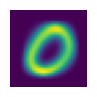

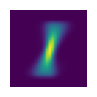

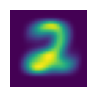

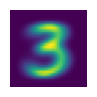

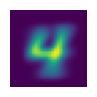

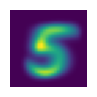

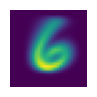

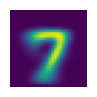

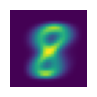

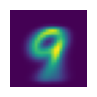

In [7]:
# Finding the ideal image for every digit and then displaying them
for i in range(0,10):
  show_image(stacked_nums[i].mean(0))

In [8]:
# Creating tensors for the validation dataset
valid_num_tens = []
for i in range(0, 10):
  valid_num_tens.append(torch.stack([tensor(Image.open(o)) for o in (path/'testing'/f'{i}').ls()]))

In [9]:
# Creating normalized pixel values for the tensors in the validation dataset
valid_num_tens_normalized =[]
for i in valid_num_tens:
  valid_num_tens_normalized.append(i.float()/255)

In [10]:
# Creating the features and the labels
train_x = torch.cat(stacked_nums).view(-1, 28*28) # Flattening each image into a row with 784 cols
train_y = []
for i in range(0,10):
    train_y.append(tensor([i]*len(numbers[i])))
train_y = torch.cat(train_y)

In [11]:
# Creating the training dataset
dset = list(zip(train_x, train_y))

In [12]:
# Creating the features and labels of the validation dset
valid_x = torch.cat(valid_num_tens_normalized).view(-1, 28*28)
valid_y = []
for i in range(0,10):
    valid_y.append(tensor([i]*len(valid_num_tens_normalized[i])))
valid_y = torch.cat(valid_y)

In [13]:
# Creating the validation dset
valid_dset = list(zip(valid_x, valid_y))

In [14]:
# Creating our Loss function
loss_func = nn.CrossEntropyLoss()

In [15]:
# Applies softmax function to the model's logits because multiclass classification is being done
def mnist_loss(preds, target):
   loss = loss_func(preds, target)
   return loss.mean()

In [16]:
# Creating DataLoaders for both our training dset and validation dset
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

In [17]:
# Calculates the gradient
def calc_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

In [18]:
# Evaluates the accuracy at each iteration
def batch_accuracy(xb, yb):
  probs = F.softmax(xb, dim=1)
  correct = (torch.argmax(probs, dim=1) == yb)
  return correct.float().mean()

In [19]:
def validate_epoch(model):
  """Evaluates model accuracy at each iteration,
  using validation dset"""
  accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
  return round(torch.stack(accs).mean().item(), 4)

In [20]:
linear_model = nn.Linear(28*28,10) # Expects 784 inputs and 10 output neurons
w, b = linear_model.parameters() # weights, biases

In [21]:
# Basic Optimizer
class BasicOptim:
  def __init__(self, params, lr):
    self.params = list(params)
    self.lr = lr

  def step(self, *args, **kwargs):
    for p in self.params:
      p.data -= p.grad.data * self.lr

  def zero_grad(self, *args, **kwargs):
      for p in self.params:
        p.grad = None

In [22]:
# Instance of BasicOptim
opt = BasicOptim(linear_model.parameters(), lr=1.)

In [23]:
def train_epoch(model):
  """Trains model at each epoch, calculates gradient,
  makes step and then clears gradient"""
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    opt.step()
    opt.zero_grad()

In [24]:
def train_model(model, epochs):
  """Trains model through whole dataset,
  evaluates using validation dset"""
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=' ')

In [25]:
# Creating DataLoaders
dls = DataLoaders(dl, valid_dl)

In [26]:
"""Simple network with 800 neurons in hidden layer,
and ten neurons in output layer """
simple_net = nn.Sequential(
    nn.Linear(28*28, 800),
    nn.ReLU(),
    nn.Linear(800,10)
)

In [27]:
# Creating Learner
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [28]:
learn.fit(140, 0.3)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.352190,6.933843,0.100900,00:08
1,0.305609,6.131746,0.100900,00:07
2,0.250843,5.378658,0.128300,00:05
3,0.211913,5.039834,0.182500,00:04
4,0.175216,4.685506,0.210000,00:04
5,0.160996,4.289752,0.261300,00:05
6,0.139063,4.493107,0.256000,00:04
7,0.124884,4.815154,0.249100,00:04
8,0.104113,4.368789,0.261000,00:05
9,0.100355,4.269591,0.271500,00:04


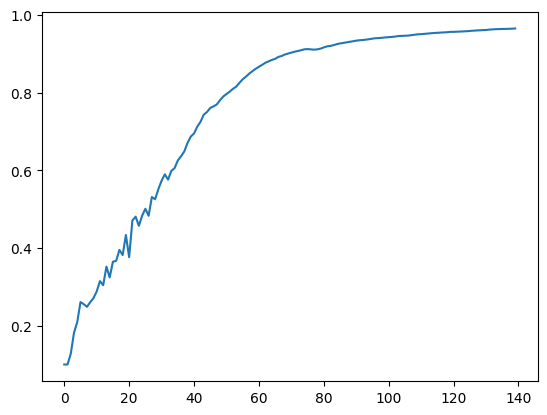

In [29]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [30]:
learn.recorder.values[-1][2]

0.9646000266075134

* This model achieves 96% accuracy
